### Seq2seq 번역기 만들기

### Step 1. 데이터 다운로드
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

- jungyeul/korean-parallel-corpora -https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

### Step 2. 데이터 정제
1) set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2) 앞서 정의한 preprocessing() 함수는 한글에 대해 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3) 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수로 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. KoNLPy가 설치되어 있지 않다면 아래 문서를 참고해 설치해 주세요.

설치하기-KoNLP https://konlpy.org/ko/latest/install/#ubuntu

- 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

### Step 3. 데이터 토큰화
    
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

### Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아질 거랍니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

### Step 5. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

### 루브릭

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.
    - 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.

2. Attentional Seq2seq 모델이 정상적으로 구동된다.
    - seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
    
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.


In [19]:
## 예문 ##
# K1) 오바마는 대통령이다.
# K2) 시민들은 도시 속에 산다.
# K3) 커피는 필요 없다.
# K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
# E1) obama is the president . <end>
# E2) people are victims of the city . <end>
# E2) the price is not enough . <end>
# E2) seven people have died . <end>

In [ ]:
# 한글폰트설치
#!sudo apt -qq -y install fonts-nanum

In [1]:
# matplotlib 폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt### Seq2seq 번역기 만들기.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

### 데이터 전처리

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.3.0


In [21]:
# #데이터 다운로드 -> get_file()함수로 URL로 부터 데이터 다운로드(압축파일일 경우 압축해제 수행)
# path_to_zip = tf.keras.utils.get_file(
#     'spa-eng.zip',
#     origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [50]:
#데이터 다운로드 -> get_file()함수로 URL로 부터 데이터 다운로드(압축파일일 경우 압축해제 수행)
# path_to_zip = tf.keras.utils.get_file(
#     'korean-english-park.train.tar.gz',
#     origin='https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz?raw=true',
#     extract=True)
#home = '/home/aiffel/aiffel/s2s_translation/korean-english-park.train'
kor_train = "/home/aiffel/aiffel/s2s_translation/korean-english-park.train/korean-english-park.train.ko"
eng_train = "/home/aiffel/aiffel/s2s_translation/korean-english-park.train/korean-english-park.train.en"


In [47]:
kor_train

'/home/aiffel/aiffel/s2s_translation/korean-english-park.train/korean-english-park.train.ko'

In [48]:
#데이터 불러오기
with open(kor_train, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


#### 데이터 전처리 : 정제하기

In [49]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r"[^[가-힣]+"," ", sentence) #한글 정규표현식
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence #시작문자

    if e_token:
        sentence += ' <end>'#종료문자
    
    return sentence

In [6]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("Korean:", enc_corpus[100])   # go away !
print("English:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


#### 데이터 전처리 : 토큰화

In [7]:
# def tokenize(corpus):
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',num_words=10000)
#     tokenizer.fit_on_texts(corpus)

#     tensor = tokenizer.texts_to_sequences(corpus)

#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

#     return tensor, tokenizer

In [ ]:
from konlpy.tag import Mecab
def tokenize(corpus):
    tokenizer = Mecab()

    output_tokens = [ '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]' ]
    for wst in whitespace_tokenize(korquad_data):   # wst : 공백,탭,엔터 기준 문자열 하나
          count = 0
          for token in tokenizer.morphs(wst):       # token : wst를 형태소 분석한 토큰 하나
              tk = token

              if count > 0:
                  tk = "##" + tk
                  output_tokens.append(tk)
              else:  # count==0
                  output_tokens.append(tk)  # 맨 처음 token만 앞에 ##을 붙이지 않음 
                  count += 1

In [8]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

#분리된 단어장 크기 확인 
print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


### 모델 설계
- 각각 1개의 GRU를 갖는 Encoder-Decoder 구조 설계
- Encoder 
    - 모든 Time-step의 Hidden State를 출력으로
- Decoder 
    - Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취함 -> tStep Hidden Stat를 만들어 냄
    - tStep의 단어로 예측된 결과 <-> 실제 정답과 대조 => Loss 값을 구함
    - tStep의 Hidden State t+1 Step의 Hidden State를 만들기 위해 다시 Decoder로 전달
    - t=1 일때 Hidden State 는 Encoder의 Final State를 사용
    - Attention은 Bahdanau을 사용
    
    

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [12]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


### 모델 훈련 
#### Optimizer & Loss

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

#### train_step 구현
- train_step()을 통해 학습에 필요한 것을 가져와 Loss를 계산한 후 반환하는 함수

In [14]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

#### 훈련 시작하기

In [15]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 375/375 [01:22<00:00,  4.53it/s, Loss 0.1421]


### 실습하기

In [16]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기

# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:06<00:00, 14.45it/s, Test Loss 0.7631]


### 평가하기

Input: can i have some coffee ?
Predicted translation: puedo tomar un poco caf ? <end> 


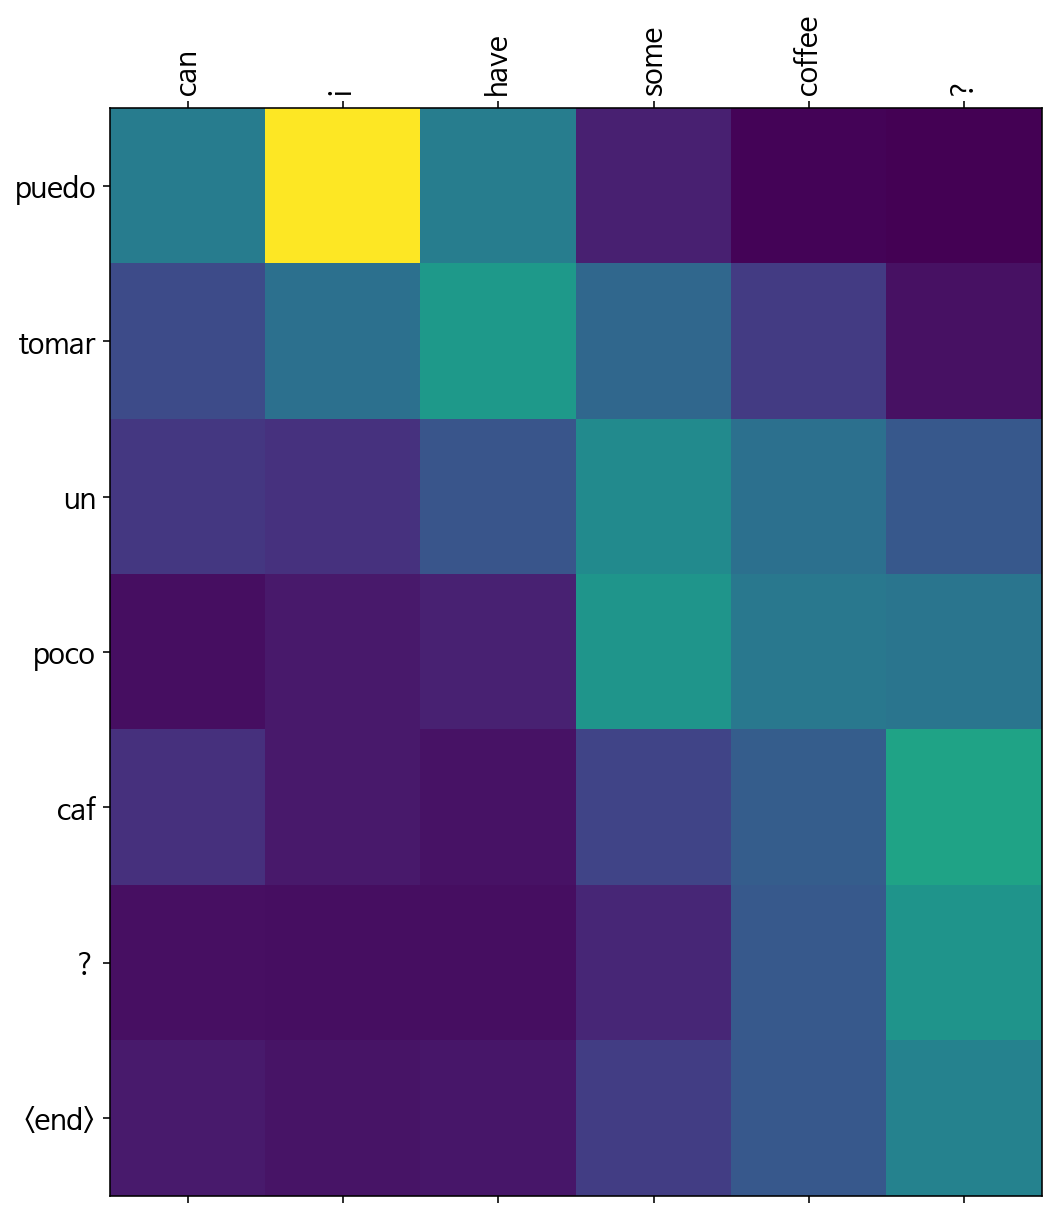

In [17]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)

### 회고 
- 2개로 분리된 데이터를 정제하는 과정의 코드 구현이 잘 이루어지지 않음
- 한글 정규표현식 적용이 잘 이루어지지 않음
- mecab() 을 이용한 한글 토크나이저 함수 선언과 적용이 잘 이루어지지 않음